In [1]:
import gym
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.
c:\tools\anaconda3\envs\ztdl-tf-1\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\tools\anaconda3\envs\ztdl-tf-1\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\tools\anaconda3\envs\ztdl-tf-1\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\tools\anaconda3\envs\ztdl-tf-1\lib\site-packages\t

In [2]:
EPISODES = 1000

In [3]:
class A2CAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        
        self.discount_factor = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.005
        
        self.actor = self._build_actor()
        self.critic = self._build_critic()
        self.actor_updater = self._actor_optimizer()
        self.critic_updator = self._critic_optimizer()
        
    def _build_actor(self):
        actor = Sequential()
        actor.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax', kernel_initializer='he_uniform'))
        actor.summary()
        return actor
    
    def _build_critic(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        critic.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear', kernel_initializer='he_uniform'))
        critic.summary()
        return critic
    
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]
    
    def _actor_optimizer(self):
        action = K.placeholder(shape=[None, self.action_size])
        advantage = K.placeholder(shape=[None,])
        
        action_prob = K.sum(action * self.actor.output, axis=1)
        cross_entropy = K.log(action_prob) * advantage
        loss = -K.sum(cross_entropy)
        
        optimizer = Adam(lr=self.actor_lr)
        updates = optimizer.get_updates(self.actor.trainable_weights, [], loss)
        train = K.function([self.actor.input, action, advantage], [], updates=updates)
        return train
    
    def _critic_optimizer(self):
        target = K.placeholder(shape=[None,])
        
        loss = K.mean(K.square(target - self.critic.output))
        
        optimizer = Adam(lr=self.critic_lr)
        updates = optimizer.get_updates(self.critic.trainable_weights, [], loss)
        train = K.function([self.critic.input, target], [], updates=updates)
        
        return train
    
    def train_model(self, state, action, reward, next_state, done):
        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]
        
        act = np.zeros([1, self.action_size])
        act[0][action] = 1
        
        if done:
            advantage = reward - value
            target = [reward]
        else:
            advantage = (reward + self.discount_factor * next_value) - value
            target = reward + self.discount_factor * next_value
            
        self.actor_updater([state, act, advantage])
        self.critic_updator([state, target])

In [4]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = A2CAgent(state_size, action_size)

scores, episodes = [], []
done_train = False

for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, -1])
    
    while not done:
        if agent.render:
            env.render()
            
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, -1])
        reward = reward if not done or score == 499 else - 100
        
        agent.train_model(state, action, reward, next_state, done)
        
        score += reward
        state = next_state
        
        if done:
            score = score if score == 500.0 else score + 100
            scores.append(score)
            episodes.append(e)
            
            print(e, score)
            
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                done_train = True
                break
                
    if done_train:
        break

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_5 (Dense)             

In [5]:
import matplotlib.pyplot as plt

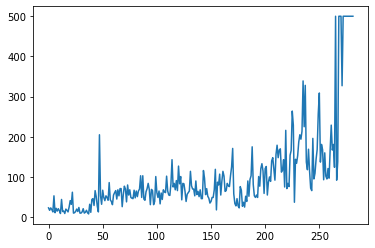

In [6]:
plt.plot(episodes, scores)